In [3]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from time_series_influences.anomaly_detection import eval_anomaly_detector

In [4]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 10
BIGGER_SIZE = 10
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=.5)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=1)
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.minor.size'] = 3

In [5]:
data_path = Path("../data/univariate/UCR/data/")
score_path = Path("./UCR_Scores_Comparison/")
datasets = os.listdir(score_path)
detectors = ["InfluenceFunction", "IForest", "LSTM", "ARIMA", "AnomalyTransformer"]

In [6]:
datasets = ['037', '003', '062', '151']

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
anomaly_scores_dict, metrics_dict = {}, {}
for dataset in datasets:
    anomaly_scores_dict[dataset] = {}
    metrics_dict[dataset] = {}
    for fname in os.listdir(data_path):
        if fname.startswith(dataset):   
            ts = pd.read_csv(data_path/fname, delimiter='\t', header=None).to_numpy().squeeze()
            train_idx = int(fname.split("_")[-3])
            anomaly_start = int(fname.split("_")[-2])
            anomaly_end = int(fname.split("_")[-1].split(".")[0])
            train_ts, test_ts = ts[:train_idx], ts[train_idx:]
            gt = np.zeros([len(test_ts)], dtype=bool)
            gt[anomaly_start-1-train_idx:anomaly_end-train_idx] = True
            # print(len(test_ts))
    anomaly_scores_dict[dataset].update({"Observed": test_ts})
    anomaly_scores_dict[dataset].update({"Label": gt})
    anomaly_scores_dict[dataset].update({"start_end": (anomaly_start-1-train_idx, anomaly_end-train_idx)})
    for detector in detectors:
        anomaly_scores = np.load(score_path/dataset/f"{dataset}_{detector}Detector_anomaly_scores", allow_pickle=True)
        scaler = MinMaxScaler()
        anomaly_scores = scaler.fit_transform(anomaly_scores.reshape(-1,1)).squeeze()
        anomaly_scores_dict[dataset].update({detector: anomaly_scores})
        contam_ratio = (anomaly_end - anomaly_start) / len(ts)
        pred = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)
        _, _, f1, auc = eval_anomaly_detector(gt[:len(pred)], pred, anomaly_scores)
        metrics_dict[dataset].update({detector: [f1, auc]})
        # print(len(anomaly_scores))

precision: 0.929 recall: 0.765 F1: 0.839 AUC: 1.000
precision: 0.536 recall: 0.294 F1: 0.380 AUC: 0.735
precision: 0.262 recall: 0.216 F1: 0.237 AUC: 0.729
precision: 0.262 recall: 0.216 F1: 0.237 AUC: 0.714
precision: 0.024 recall: 0.020 F1: 0.022 AUC: 0.549
precision: 1.000 recall: 0.561 F1: 0.719 AUC: 1.000
precision: 0.000 recall: 0.000 F1: 0.000 AUC: 0.584
precision: 0.000 recall: 0.000 F1: 0.000 AUC: 0.777
precision: 0.479 recall: 0.269 F1: 0.345 AUC: 0.936
precision: 0.006 recall: 0.003 F1: 0.004 AUC: 0.375
precision: 1.000 recall: 0.712 F1: 0.832 AUC: 1.000
precision: 0.000 recall: 0.000 F1: 0.000 AUC: 0.562
precision: 0.000 recall: 0.000 F1: 0.000 AUC: 0.713
precision: 0.025 recall: 0.018 F1: 0.021 AUC: 0.578
precision: 0.000 recall: 0.000 F1: 0.000 AUC: 0.580
precision: 1.000 recall: 0.590 F1: 0.742 AUC: 0.983
precision: 0.106 recall: 0.062 F1: 0.078 AUC: 0.434
precision: 0.115 recall: 0.068 F1: 0.086 AUC: 0.379
precision: 0.031 recall: 0.019 F1: 0.023 AUC: 0.841
precision: 0

In [22]:
detectors

['InfluenceFunction', 'IForest', 'LSTM', 'ARIMA', 'AnomalyTransformer']

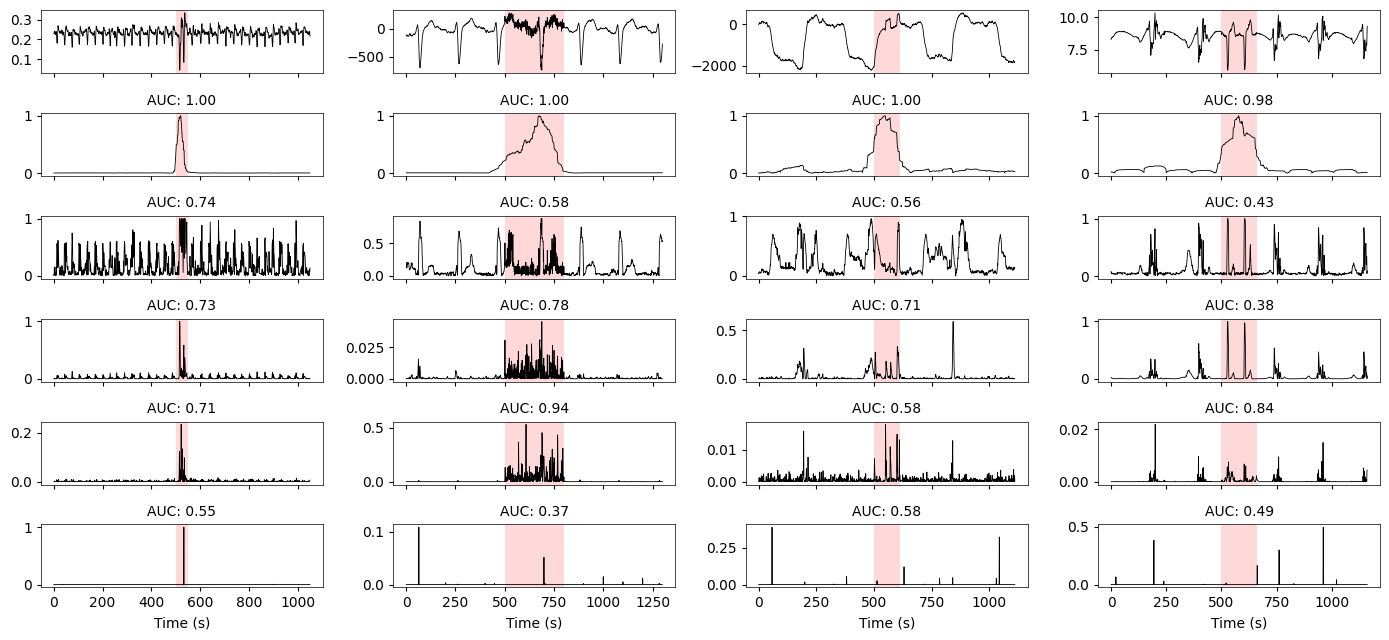

In [24]:
offset = 500
block_len = 100

fig, axes = plt.subplots(len(detectors)+1, len(datasets), figsize=(14,6.5))

for j in range(len(datasets)):
    start, end = anomaly_scores_dict[datasets[j]]["start_end"]
    obs = anomaly_scores_dict[datasets[j]]["Observed"][start-offset:end+offset]
    axes[0,j].plot(obs, color="k", linewidth=.6)
    axes[0,j].tick_params(labelbottom=False)    
    axes[-1,j].set_xlabel("Time (s)")
    axes[0,j].axvspan(offset, end-start+offset, facecolor='r', alpha=.15)

for i in range(len(detectors)):
    # axes[i+1,0].set_ylabel(detectors[i])
    for j in range(len(datasets)):
        start, end = anomaly_scores_dict[datasets[j]]["start_end"]
        scores = anomaly_scores_dict[datasets[j]][detectors[i]][start-offset:end+offset]
        axes[i+1,j].plot(scores, color="k", linewidth=.6)
        axes[i,j].tick_params(labelbottom=False)  
        axes[i+1,j].axvspan(offset, end-start+offset, facecolor='r', alpha=.15)
        f1, auc = metrics_dict[datasets[j]][detectors[i]]
        axes[i+1,j].set_title(f"AUC: {auc:.2f}", fontsize=10)
        # axes[i+1,j].set_ylim(0, 1)
        # axes[i,j].set_yticks(axes[i,j].get_yticks(), axes[i,j].get_yticklabels(), ha='right')
        
plt.tight_layout()
# plt.savefig("./plots/anomaly_patterns.png", dpi=500)